In [1]:
library("ape")
library("phytools")
library("caper")
library("geiger")
library("readxl")
library("tidyverse")
library("compositions")

Loading required package: maps

Loading required package: MASS

Loading required package: mvtnorm

── Attaching core tidyverse packages ──────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks maps::map()
✖ dplyr::select() masks MASS::select()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following object is masked from ‘package:ape’:

    balance


The following objects are masked from ‘p

In [2]:
change_species_in_bergeron_tree_to_lowercase <- function(tree_filename) {
    tree <- read.tree(tree_filename)
    cat("binary:", is.binary(tree), "\n") 
    cat("ultrametric:", is.ultrametric(tree), "\n")
    # 74 species in original tree
    for (nn in tree$tip.label) {
      tmp <- tolower(nn)
      tree$tip.label <- stringr::str_replace_all(tree$tip.label, nn, tmp)
    }
    return(tree)
}

load_and_process_csv <- function(csv_filename) {
    df <- read.csv(csv_filename)
    # column names: "species", "group", "perc_CpG.TpG", "mutation.count", "gen_time", "u_year_non_modeled", "u_modeled", "u_gen_non_modeled", 
    # "u_CpG_gen_non_modeled", "u_CpG_year_non_modeled" "diversity", "Ne", "Ne.g"  
    rownames(df) <- df$species
    df$log_u_gen <- log10(df$u_gen_non_modeled)
    df$log_u_year <- log10(df$u_year_non_modeled)
    df$log_Ne <- log10(df$Ne)
    df$log_Ne.gen <- log10(df$Ne.g)
    df$log_gen_year <- log10(df$gen_time)
    df <- dplyr::select(df, species, log_u_gen, log_u_year, log_Ne, log_Ne.gen, log_gen_year)
    return (df)
}

trim_tree_branches <- function (tree, df) {
    # trim off tree branches corresponding to species that are not found in the dataframe
    name_check <- name.check(tree, df)
    new_tree <- drop.tip(tree, name_check$tree_not_data)
    name.check(new_tree, df)
    return(new_tree)
}

load_and_trim_bergerons_tree <- function(df) {
    tree_orig = change_species_in_bergeron_tree_to_lowercase("./output/calibrated_bergeron_tree.nwk")
    tree_trim = trim_tree_branches(tree_orig, df)
    cat(length(tree_orig$tip.label), "species in the original tree,", length(tree_trim$tip.label), "species in the trimmed tree\n")
    cat(nrow(df), "species in the dataframe\n")
    return(tree_trim)
}

In [3]:
# lower case version of species name in Wang's tree
wang_tree_map_to_bergeron_species_name <- c(
    'pelecanus_occidentalis' = 'pelecanus_crispus',
    'phoenicopterus' = 'phoenicopterus_roseus',
    'cyanistes_caeruleus_caeruleus' = 'cyanistes_caeruleus',
    'turdus_merula_merula' = 'turdus_merula',
    'gyps' = 'gyps_fulvus', 
    'homo_sapiens_neanderthalensis' = 'homo_sapiens',
    'pan_troglodytes_troglodytes' = 'pan_troglodytes', 
    'hylobates_lar_lar' = 'hylobates_lar', 
    'cavia_aperea_guianae' = 'cavia_aperea',
    'mus_musculus_musculus' = 'mus_musculus', 
    'cervus_hanglu' = 'cervus_elaphus_yarkandensis',
    'cervus_nippon_centralis' = 'cervus_nippon',
    'giraffa_reticulata' = 'giraffa_camelopardalis',
    'ceratotherium_simum' = 'ceratotherium_simum_simum',
    'ailurus' = 'ailurus_fulgens',
    'neogale_vison' = 'neovison_vison'
)

wang_tree_map_to_bergeron_species_name <- c(
    'pelecanus_crispus' = 'pelecanus_occidentalis',
    'ceratotherium_simum' = 'ceratotherium_simum_mum'
)

load_and_trim_wangs_tree <- function(df, wang_tree_map_to_bergeron_species_name) {
    tree <- read.tree("./data/filtered_unique_species.nwk")
    cat("binary:", is.binary(tree), "\n") 
    cat("ultrametric:", is.ultrametric(tree), "\n")
    # 126 species, 250 edges
    length(tree$tip.label) 
    # convert to lower case
    for(nn in tree$tip.label){
        tmp <- tolower(nn)
        map_name = wang_tree_map_to_bergeron_species_name[tmp]
        if (!is.na(map_name)) {
            tmp <- map_name
        }
        tree$tip.label <- stringr::str_replace_all(tree$tip.label, nn, tmp)
    }
    name_check <- name.check(tree, df)
    tree_trim <- drop.tip(tree, name_check$tree_not_data)
    cat(length(tree$tip.label), "species in the original tree,", length(tree_trim$tip.label), "species in the trimmed tree\n")
    cat(nrow(df), "species in the dataframe\n")
    return(tree_trim)
}

In [4]:
cat("Bergeron's tree: \n")
df = load_and_process_csv("./output/df_bergeron_merge.csv")
tree_berg = load_and_trim_bergerons_tree(df)

cat("\nWang's tree:\n")
tree_wang <- load_and_trim_wangs_tree(df, wang_tree_map_to_bergeron_species_name)
label_diff <- setdiff(tree_berg$tip.label, tree_wang$tip.label)
cat("number of different species in bergeron's tree vs wang's", length(label_diff), "\n")

Bergeron's tree: 
binary: TRUE 
ultrametric: TRUE 
74 species in the original tree, 62 species in the trimmed tree
62 species in the dataframe

Wang's tree:
binary: TRUE 
ultrametric: TRUE 
126 species in the original tree, 46 species in the trimmed tree
62 species in the dataframe
number of different species in bergeron's tree vs wang's 16 


In [5]:
run_pgls <- function(df, tree, x_name, y_name, lambda, print_plot) {
    taxa <- comparative.data(tree, df, "species", vcv=TRUE)
    fm <- as.formula(paste(y_name, "~", x_name))
    model <- pgls(formula=fm, data=taxa, lambda=lambda)
    coeff <- coefficients(model)
    intercept <- coeff[1]
    slope <- coeff[2]
    Ne_u_plot <- ggplot(data=df, aes_string(x=x_name, y=y_name)) + geom_point()
    Ne_u_plot <- Ne_u_plot + geom_smooth(formula=y~x, method="lm") + geom_abline(intercept = intercept, slope = slope)
    if (print_plot) {
        print(Ne_u_plot + labs(y=y_name, x=x_name))
    }

    res<- residuals(model, phylo = TRUE)
    res<- res/sqrt(var(res))[1]
    
    return(model)
}

save_summary_data <- function(model, print_output, save_output, save_filename="output_file.csv") {
    model_summary <- summary(model)
    # names(summary(model_summary))
    lambda <- model_summary$param.CI$lambda$opt
    lambda.ci.val <- model_summary$param.CI$lambda$ci.val
    lambda.bounds <- model_summary$param.CI$lambda$bounds.val
    lambda.p <- model_summary$param.CI$lambda$bounds.p
    
    coeff <- model_summary$coefficients[,1]
    coeff.p <- model_summary$coefficients[,4]
    if (print_output) {
        cat("lambda: ", lambda, ", CI of lambda: ", lambda.ci.val, "\n")
        cat("coefficients: ", coeff, ", p-value: ", coeff.p, "\n")
    }

    if (save_output) {
        df_out <- t(data.frame(c(lambda, lambda.ci.val, lambda.bounds, lambda.p, coeff, coeff.p)))
        colnames(df_out) <- c("lambda", "lambda.ci.low", "lambda.ci.high", "lambda.bounds.low", "lambda.bounds.high", "lambda.p.low", "lambda.p.high", "intercept", "slope", "intercept.p", "slope.p")
        rownames(df_out) <- c(1)
        write.csv(df_out, save_filename)
    }
}

## Clocklike DBH plots, mutation rate (per year, per generation) vs Ne (* generation time)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


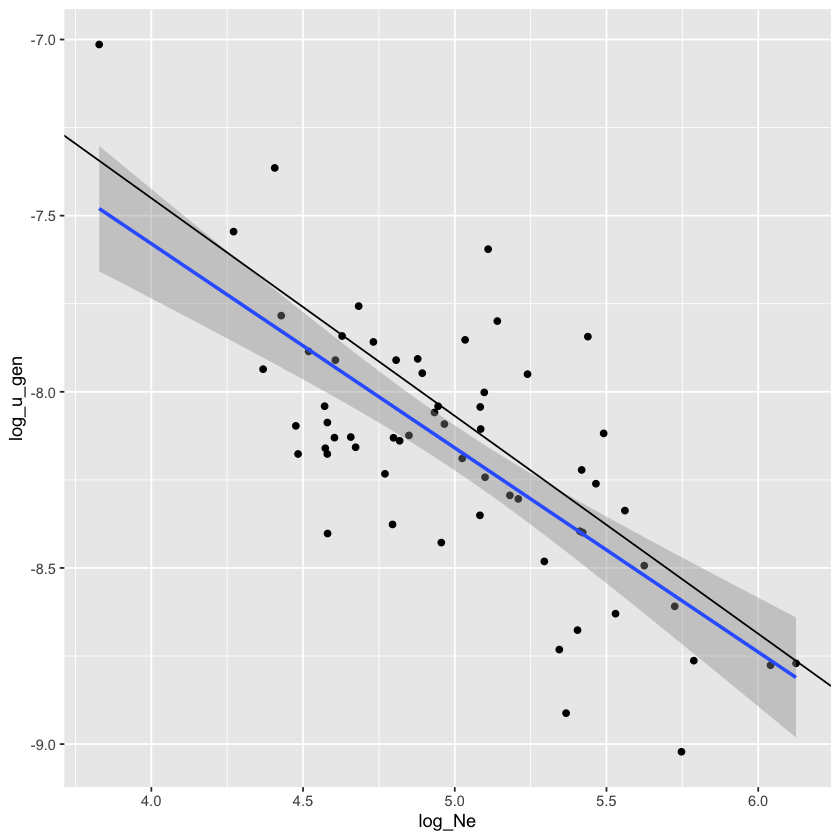

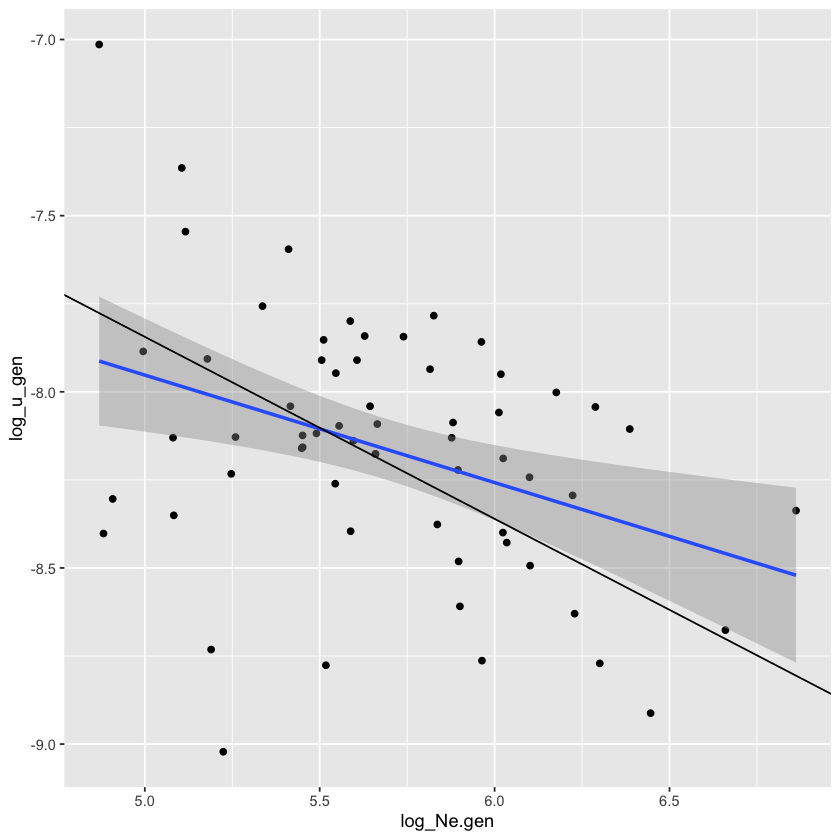

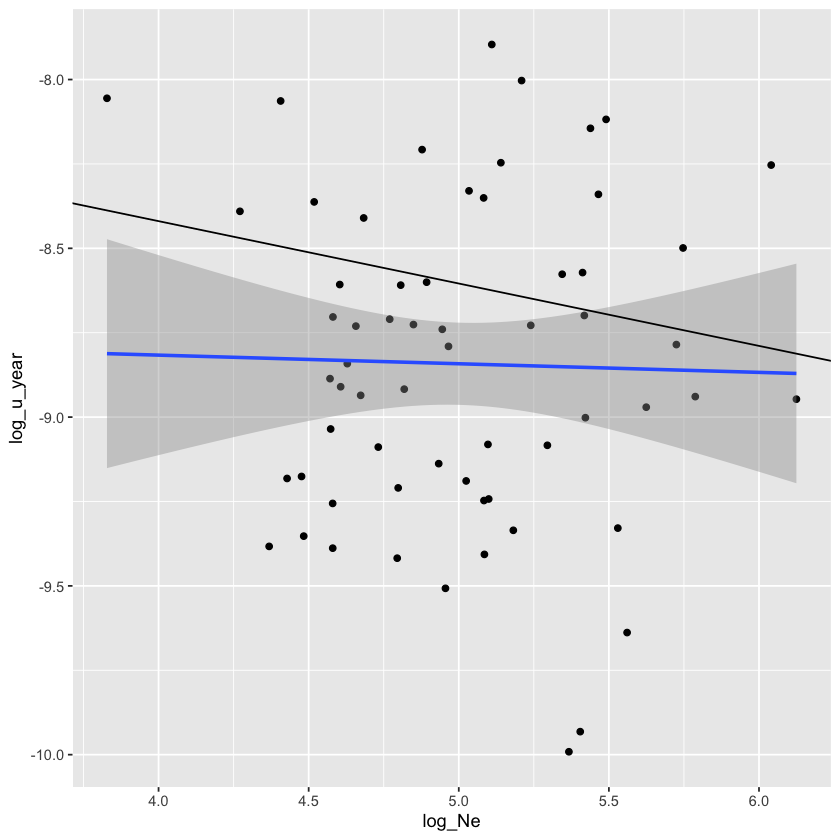

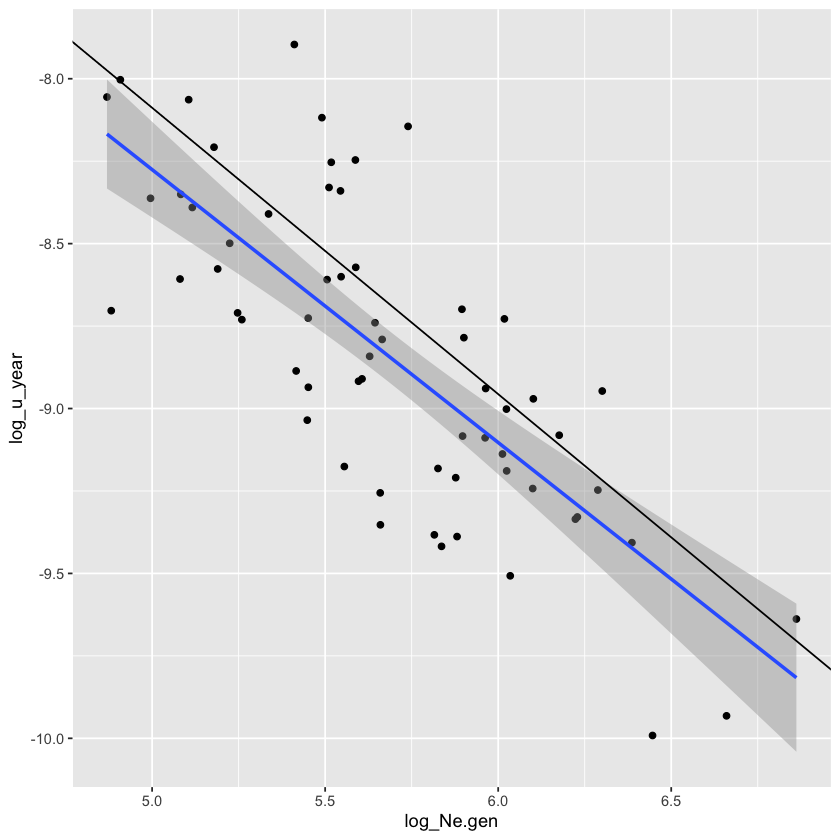

In [6]:
lambda <- "ML"
model.u_gen.Ne <- run_pgls(df, tree_berg, "log_Ne", "log_u_gen", lambda=lambda, print_plot=TRUE)
model.u_gen.Ne_g <- run_pgls(df, tree_berg, "log_Ne.gen", "log_u_gen", lambda=lambda, print_plot=TRUE)
model.u_year.Ne <- run_pgls(df, tree_berg, "log_Ne", "log_u_year", lambda=lambda, print_plot=TRUE)
model.u_year.Ne_g <- run_pgls(df, tree_berg, "log_Ne.gen", "log_u_year", lambda=lambda, print_plot=TRUE)

## Reviewer 1, yearly mutation rate on generation time

### Bergeron's data

lambda 
 1e-06

[1]        NA 0.7318077

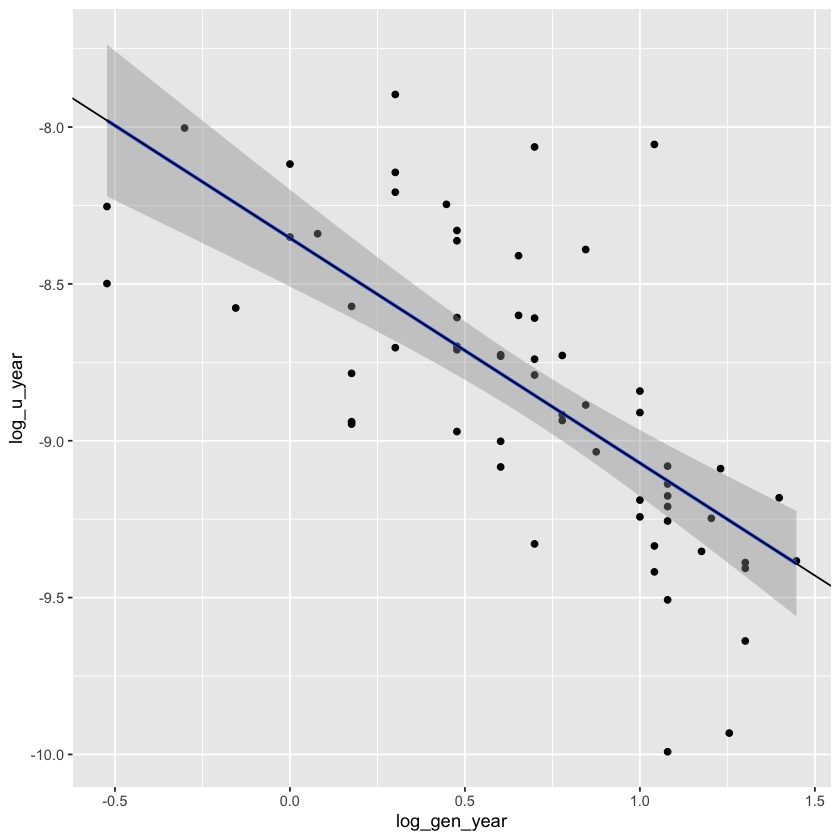

In [7]:
lambda <- "ML"
model.u_year.g <- run_pgls(df, tree_berg, "log_gen_year", "log_u_year", lambda=lambda, print_plot=TRUE)
summary(model.u_year.g)$param.CI$lambda$opt
summary(model.u_year.g)$param.CI$lambda$ci.val
save_summary_data(model.u_year.g, print_output=FALSE, save_output=TRUE, save_filename="output/r_bergeron/mu_year_gen.csv")

### Wang's data

lambda 
 1e-06

[1]        NA 0.3731098

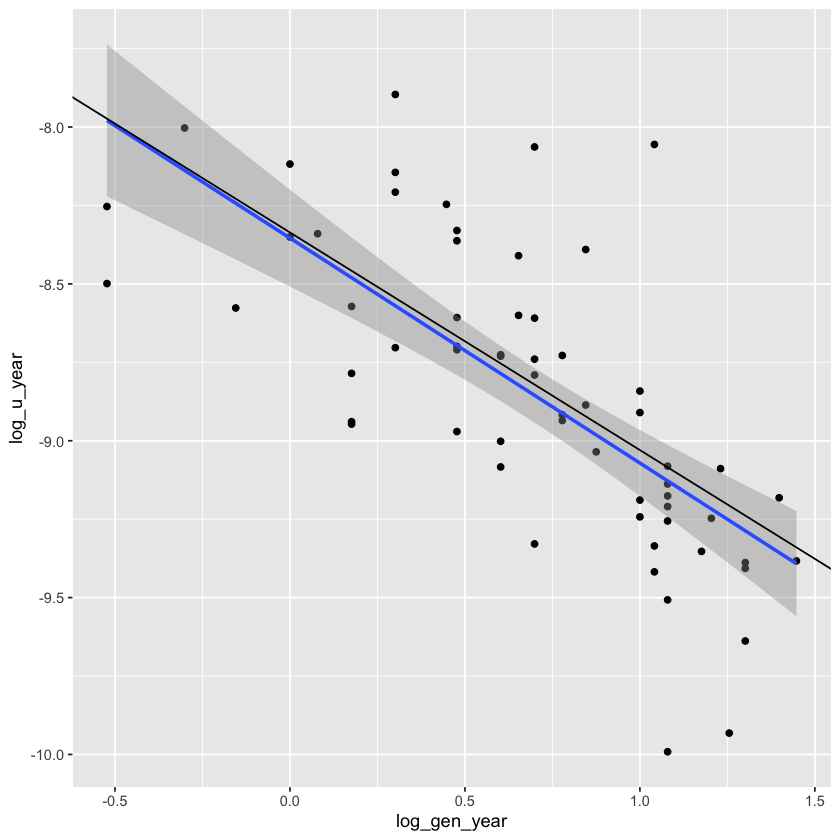

In [8]:
lambda <- "ML"
model.u_year.g <- run_pgls(df, tree_wang, "log_gen_year", "log_u_year", lambda=lambda, print_plot=TRUE)
summary(model.u_year.g)$param.CI$lambda$opt
summary(model.u_year.g)$param.CI$lambda$ci.val

### Regressing mutation rate (generation) on generation time (to get around circularity)


Call:
pgls(formula = fm, data = taxa, lambda = lambda)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041975 -0.009960 -0.000370  0.008325  0.050809 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.000
   lower bound : 0.000, p = 1    
   upper bound : 1.000, p = 0.0016477
   95.0% CI   : (NA, 0.732)
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error   t value  Pr(>|t|)    
(Intercept)  -8.353977   0.077234 -108.1647 < 2.2e-16 ***
log_gen_year  0.282883   0.093914    3.0122  0.003794 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01659 on 60 degrees of freedom
Multiple R-squared: 0.1314,	Adjusted R-squared: 0.1169 
F-statistic: 9.073 on 1 and 60 DF,  p-value: 0.003794 

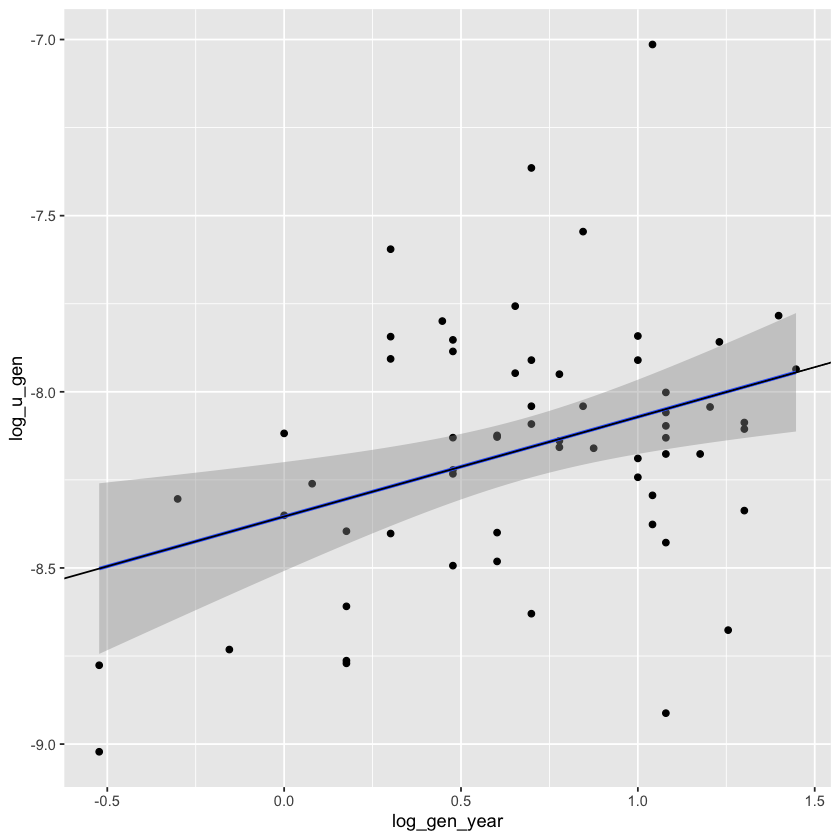

In [7]:
lambda <- "ML"
model.u_gen.g <- run_pgls(df, tree_berg, "log_gen_year", "log_u_gen", lambda=lambda, print_plot=TRUE)
summary(model.u_gen.g)
# save_summary_data(model.u_gen.g, print_output=FALSE, save_output=TRUE, save_filename="output/r_bergeron/mu_gen_gen.csv")

## Regression of mutation proportion on generation time

C>A lambda = 1e-06 


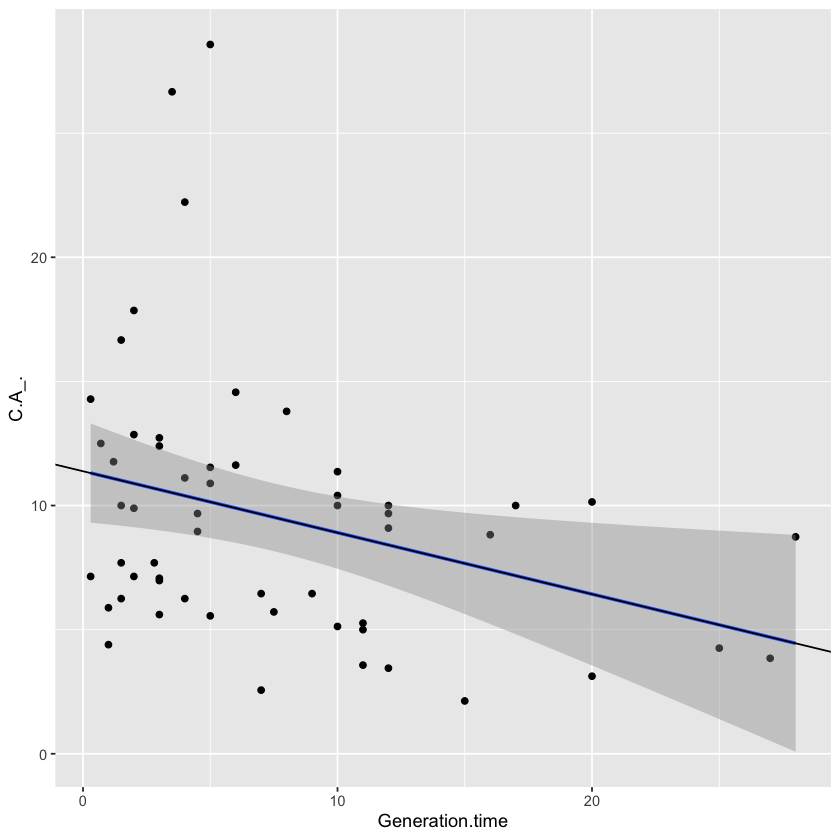

C>G lambda = 1e-06 


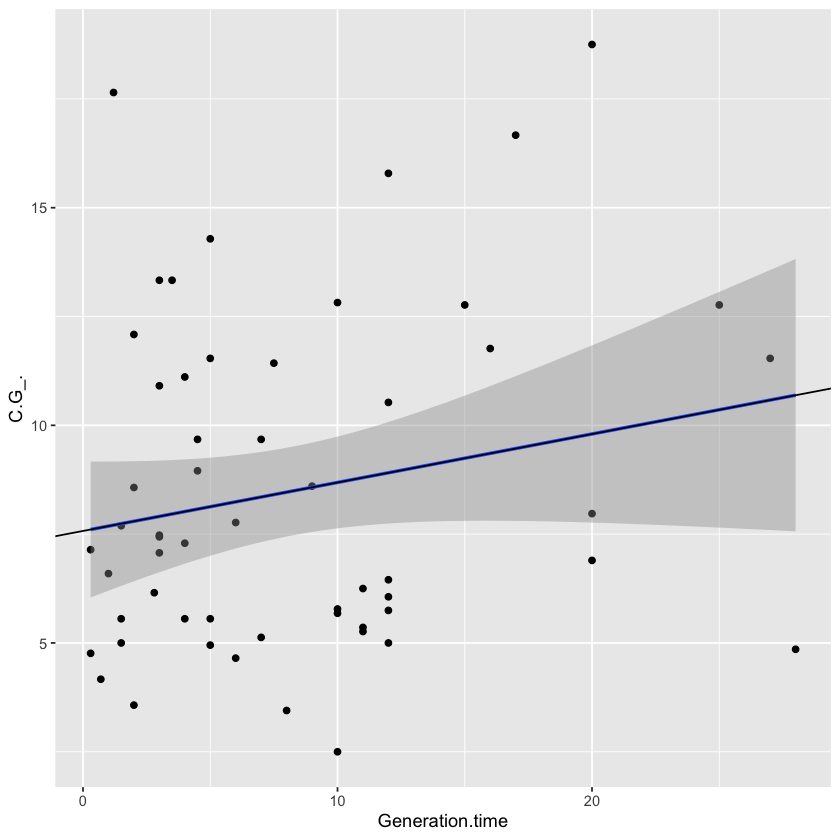

C>T_noCpG lambda = 1e-06 


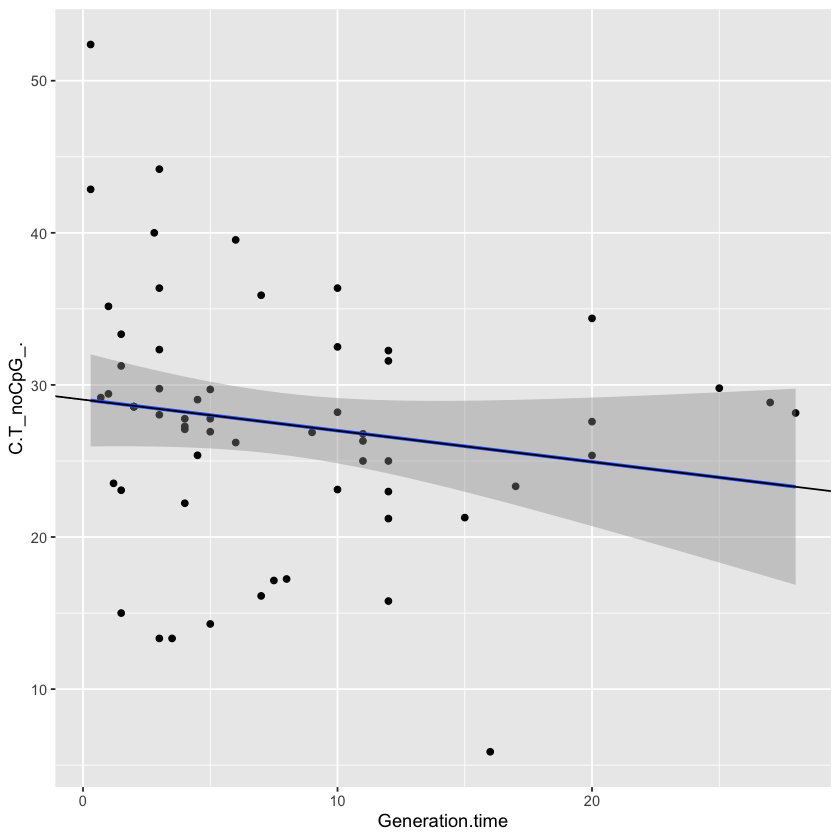

C>T_CpG lambda = 1e-06 


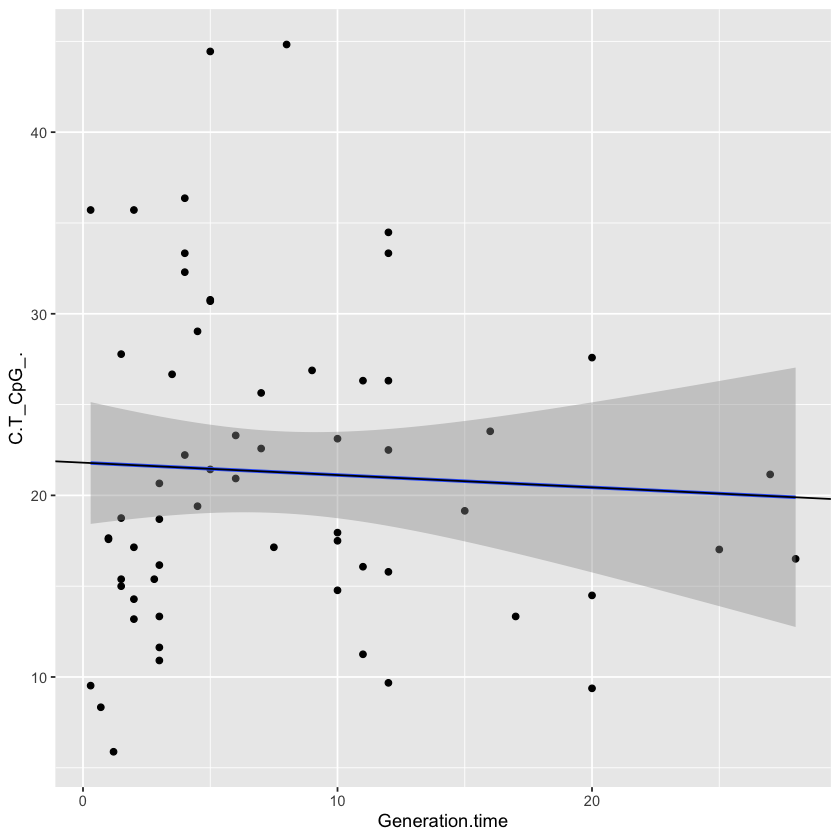

A>T lambda = 1e-06 


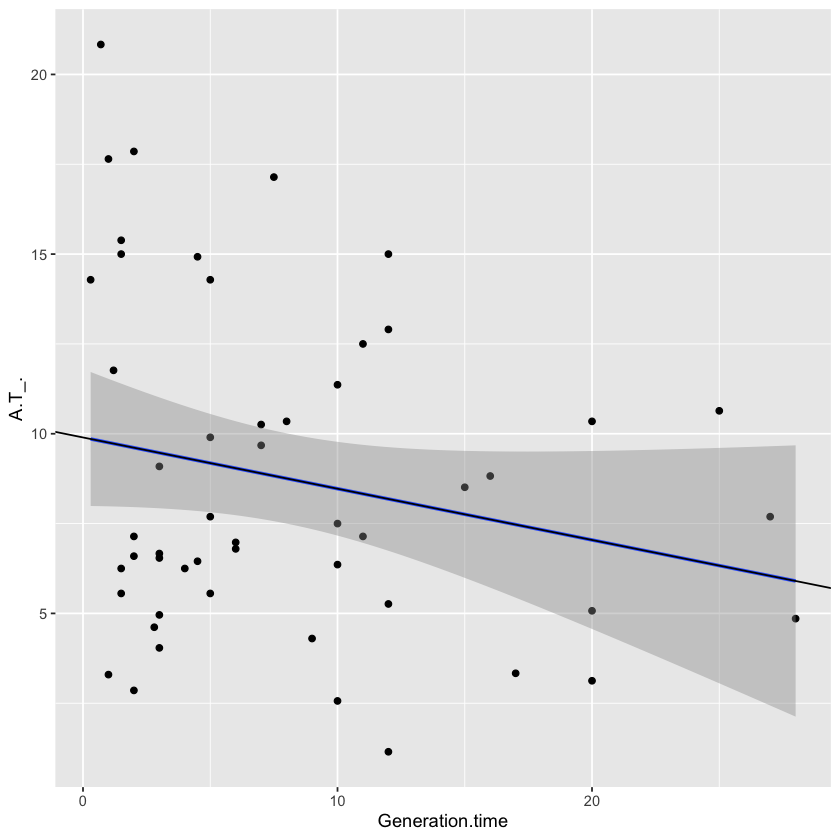

A>G lambda = 1e-06 


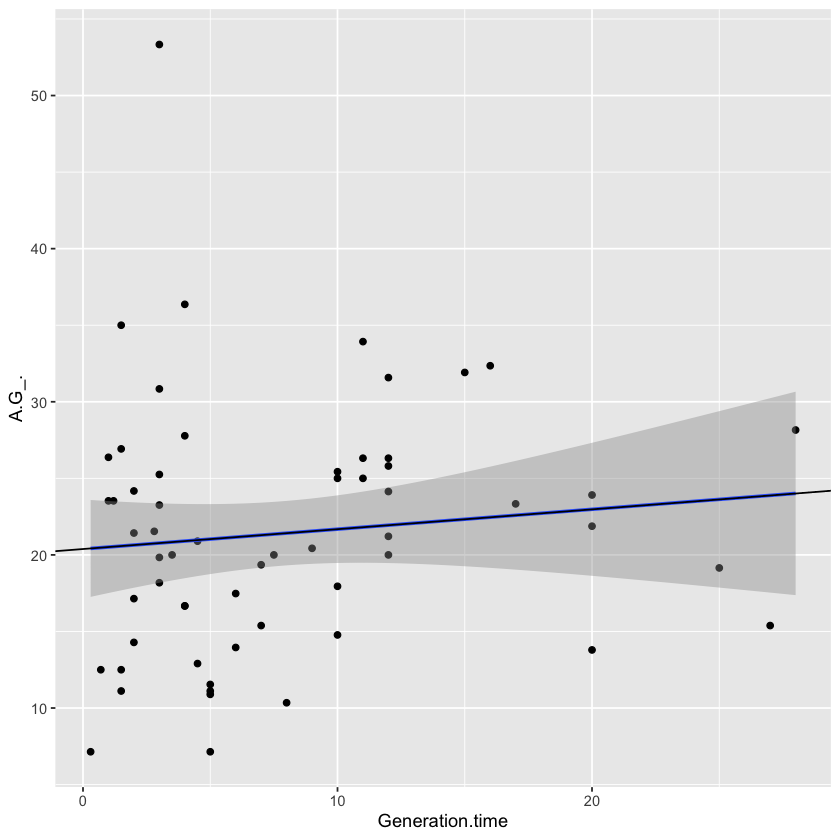

A>C lambda = 0.1284216 


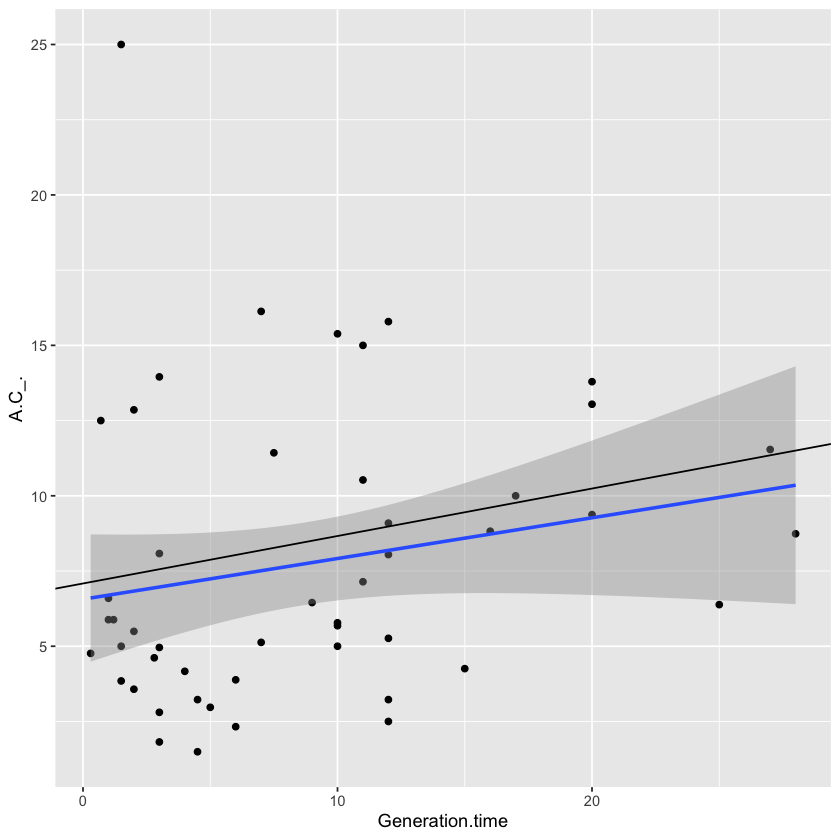

In [9]:
run_mutation_percentage_on_generation_time_regression <- function(tree) {
    mutation_types <- c("C>A_%", "C>G_%", "C>T_noCpG_%", "C>T_CpG_%", "A>T_%", "A>G_%", "A>C_%")
    lambda <- "ML"
    for (i in 1:length(mutation_types)) {
        filename <- paste("./output/mutation_subtype_vs_gen_time/csv/", mutation_types[i], ".csv", sep="")
        df <- read.csv(filename)
        rownames(df) <- df$species
        
        # load the tree
        tree <- read.tree("./output/calibrated_bergeron_tree.nwk")
        name_check <- name.check(tree, df)
        tree_trim <- drop.tip(tree, name_check$tree_not_data)
        name.check(tree_trim, df)
        stopifnot(length(tree_trim$tip.label) == nrow(df))
        
        mt <- tail(colnames(df), n=1)
        model.mp.gen <- run_pgls(df, tree, "Generation.time", mt, lambda=lambda, print_plot=TRUE)
        mt_str <- gsub("\\.", ">", str_sub(mt, end=-3))
        save_filename <- paste("output/mutation_subtype_vs_gen_time/r_output/", mt_str, ".csv", sep="")
        save_summary_data(model.mp.gen, print_output=FALSE, save_output=TRUE, save_filename=save_filename)
        cat(mt_str, "lambda =", summary(model.mp.gen)$param.CI$lambda$opt, "\n")
    }
}
run_mutation_percentage_on_generation_time_regression(tree_berg)

## ILR transformation of mutation subtypes and perform regression of generation time on mutation subtypes

In [38]:
load_mutation_subtype_proportion_data <- function(csv_filename) {
    df <- read.csv(csv_filename)
    rownames(df) <- df$species
    df$C_A <- df$C.A_.
    df$C_G <- df$C.G_.
    df$C_T_CpG <- df$C.T_CpG_.	
    df$C_T_noCpG <- df$C.T_noCpG_.	
    df$A_C <- df$A.C_.
    df$A_G <- df$A.G_.
    df$A_T <- df$A.T_.	
    df$gen <- df$Generation.time
    df <- dplyr::select(df, species, C_A, C_G, C_T_CpG, C_T_noCpG, A_C, A_G, A_T, gen)
    
    return(df)
}

run_gen_time_on_mutation_subtype_multi_regression <- function() {
    df <- load_mutation_subtype_proportion_data("./output/mutation_subtype_vs_gen_time/csv/all.csv")
    df_ilr <- ilr_transformation(df)
    
    tree <- read.tree("./output/calibrated_bergeron_tree.nwk")
    name_check <- name.check(tree, df_ilr)
    tree_trim <- drop.tip(tree, name_check$tree_not_data)
    name.check(tree_trim, df_ilr)
    stopifnot(length(tree_trim$tip.label) == nrow(df_ilr))
    
    taxa <- comparative.data(tree_trim, df_ilr, "species", vcv=TRUE)
    model <- pgls(formula=gen ~ V1 + V2 + V3 + V4 + V5 + V6, data=taxa, lambda=lambda)
    # model <- pgls(formula=gen ~ C_A + C_G + C_T_CpG + C_T_noCpG + A_C + A_G, data=taxa, lambda=lambda) # + A_T
    # coeff <- coefficients(model)
    model_summary <- summary(model)
    print(model_summary)
}

ilr_transformation <- function(df) {
    df <- load_mutation_subtype_proportion_data("./output/mutation_subtype_vs_gen_time/csv/all.csv")               
    m <- data.matrix(dplyr::select(df, C_A, C_G, C_T_CpG, C_T_noCpG, A_C, A_G, A_T))
    z <- ilr(m)
    df_ilr <- as.data.frame(z)
    df_final <- cbind(df_ilr, species=df$species, gen = df$gen)
    return(df_final)
}

run_gen_time_on_mutation_subtype_multi_regression()


Call:
pgls(formula = gen ~ V1 + V2 + V3 + V4 + V5 + V6, data = taxa, 
    lambda = lambda)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7017 -0.2964  0.0119  0.2365  1.5304 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.784
   lower bound : 0.000, p = 1    
   upper bound : 1.000, p = 0.019714
   95.0% CI   : (NA, 0.990)
delta  [Fix]  : 1.000

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  7.678013   6.241857  1.2301   0.2274
V1           3.230065   2.039732  1.5836   0.1228
V2          -0.949531   2.612411 -0.3635   0.7186
V3          -0.738797   2.756813 -0.2680   0.7904
V4           3.099352   1.999335  1.5502   0.1306
V5           1.062757   3.297510  0.3223   0.7493
V6          -0.051557   1.771551 -0.0291   0.9770

Residual standard error: 0.5192 on 33 degrees of freedom
Multiple R-squared: 0.2246,	Adjusted R-squared: 0.08356 
F-statistic: 1.593 on 6 and 33 DF,  p-value: 0.1804 
